GitHub Link:

In [28]:
#Load the data
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, datasets
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
df = pd.read_excel("titanic3.xls", engine='xlrd')

In [29]:
print(df.dtypes)

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


Our goal is finding out the predidted survival rate of the Titanic passangers. The features of the dataset is the passanger's class ticket, if they sruvived the Titanic or not, their names, gender, and age, how many of them were siblings or spouces, or parents and children, how much their ticket number, how much the ticket price was, their cabin number, where they started the journey, what the life boat they got on was if they survived, if their body had been found what was the body number, what their home desitination was if they survived.


The target variable will be the survival feature as we're trying to find out what the survival rate of the passage is.

In [30]:
#Drop unwanted features
df = df.drop(['name', 'ticket', 'fare', 'cabin', 'boat', 'body', 'home.dest'], axis=1)
print(df.dtypes)

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
embarked     object
dtype: object


In [31]:
#How many nulls there are in each of the remaining features
print(df.isnull().sum())
#There are 263 in age and 2 in embarked

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
embarked      2
dtype: int64


In [32]:
#Fill in the null values for age
df['age'] = df['age'].fillna(df['age'].median())

In [33]:
#Drop the null values for embarked
df = df.dropna(subset='embarked')

In [34]:
#Check for nulls
print(df.isnull().sum())

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
embarked    0
dtype: int64


In [35]:
#Drop duplicates
titanic_clean = df.drop_duplicates()

In [36]:
#Check for inconsitent unique values in categorical data
print(titanic_clean['sex'].unique())
print(titanic_clean['embarked'].unique())


['female' 'male']
['S' 'C' 'Q']


In [37]:
#Change the categorical variables into numeric variables
titanic_clean['sex'] = titanic_clean['sex'].map({'female': 1, 'male': 0})
print(titanic_clean['sex'].unique())

[1 0]


<ipython-input-37-976eeb07136c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_clean['sex'] = titanic_clean['sex'].map({'female': 1, 'male': 0})


In [38]:
#Change the categorical variables into numeric variables
titanic_clean['embarked'] = titanic_clean['embarked'].map({'S':2,'C': 1, 'Q': 0})
print(titanic_clean['embarked'].unique())

[2 1 0]


<ipython-input-38-11ba092d756a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_clean['embarked'] = titanic_clean['embarked'].map({'S':2,'C': 1, 'Q': 0})


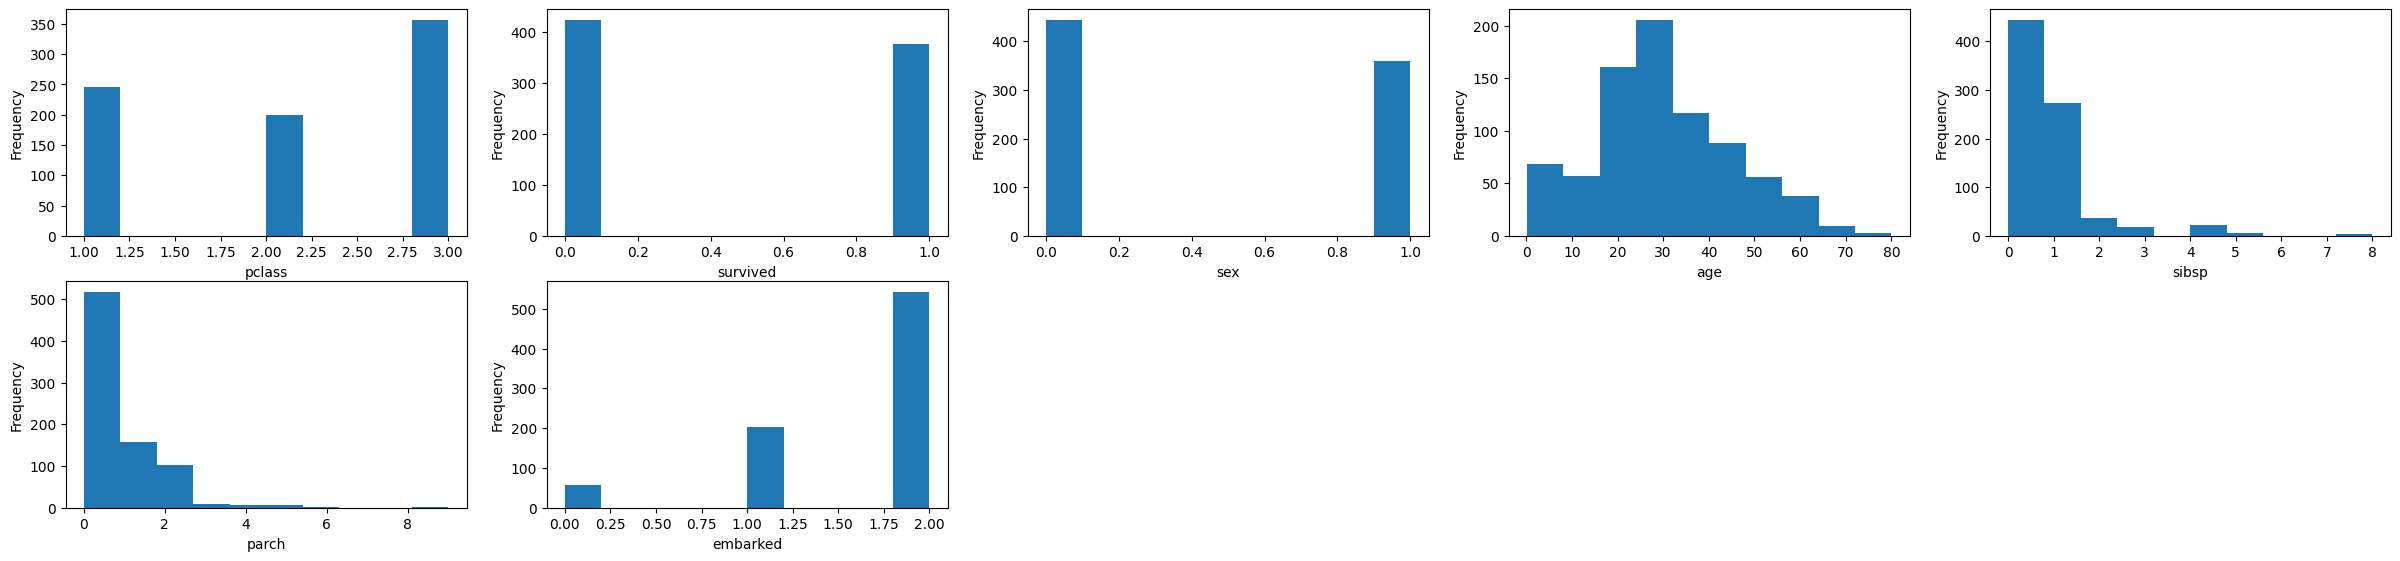

In [39]:
#Check for outliers
fig = plt.figure(figsize=(30, 10))
i=0
for column in titanic_clean:
    sub=fig.add_subplot(3,5,i+1)
    titanic_clean[column].plot(kind='hist')
    sub.set_xlabel(column)
    i=i+1
plt.show()
#Keep the outliers as it seems that sibsp and parch are connected and removing outliers for one affects the other feature

In [40]:
#Use ANVO test to reduce the dimension for numerical features
x = titanic_clean.loc[:, ['age', 'sibsp', 'parch']]
y = titanic_clean.loc[:, 'survived']

fs = SelectKBest(score_func=f_classif, k='all')
bestFeatures = fs.fit(x, y)
np.set_printoptions(suppress = True)
print(bestFeatures.scores_)
print(bestFeatures.pvalues_)

[ 6.16375183 13.01072967  0.03050167]
[0.01324346 0.00032893 0.86140099]


In [41]:
#Use chi-squared test to reduce the dimenion for categorical features
chi = SelectKBest(score_func=chi2, k='all')
x = titanic_clean.loc[:, ['pclass', 'sex', 'embarked']]
catFeatures = chi.fit(x, y)
print(catFeatures.scores_)
print(catFeatures.pvalues_)

[21.06263414 88.14113841  0.17968552]
[0.00000445 0.         0.67164364]


In [42]:
#Drop the values with the least significance
titanic_clean = titanic_clean.drop(['parch', 'embarked'], axis=1)
print(titanic_clean.dtypes)
#Parch and embarked had the least signifiance and thus was irrelevant to the data

pclass        int64
survived      int64
sex           int64
age         float64
sibsp         int64
dtype: object


In [43]:
#Use correlation analysis to see if there's any high correlated features.
print(titanic_clean.corr())
#The highest correlated feautes are sibsp with pclass and sex with survived but they themselves are not highly correlated

            pclass  survived       sex       age     sibsp
pclass    1.000000 -0.276941 -0.035877 -0.389357  0.158131
survived -0.276941  1.000000  0.446054 -0.087440 -0.126504
sex      -0.035877  0.446054  1.000000 -0.100373  0.011625
age      -0.389357 -0.087440 -0.100373  1.000000 -0.274328
sibsp     0.158131 -0.126504  0.011625 -0.274328  1.000000


None of the categorical data needs to be changed into dummy variables

In [44]:
#Normalize all the features
scaler = MinMaxScaler()
normalized_titanic_data = scaler.fit_transform(titanic_clean)
normalized_titanic = pd.DataFrame(normalized_titanic_data, columns=titanic_clean.columns)

print(normalized_titanic)

     pclass  survived  sex       age  sibsp
0       0.0       1.0  1.0  0.361169  0.000
1       0.0       1.0  0.0  0.009395  0.125
2       0.0       0.0  1.0  0.022964  0.125
3       0.0       0.0  0.0  0.373695  0.125
4       0.0       0.0  1.0  0.311064  0.125
..      ...       ...  ...       ...    ...
797     1.0       1.0  1.0  0.185803  0.125
798     1.0       0.0  0.0  0.567850  0.000
799     1.0       0.0  1.0  0.179540  0.125
800     1.0       0.0  0.0  0.329854  0.000
801     1.0       0.0  0.0  0.336117  0.000

[802 rows x 5 columns]


In [45]:
#Does this data need to be balanced?
print(titanic_clean['survived'].value_counts())
#The data is semi-balanced because while the numbers aren't even with each other, one is not majorly larger than the other

survived
0    424
1    378
Name: count, dtype: int64


In [46]:
#Use cross-validation as the data set is large and logistic regression model because it's the best way to interpret probilities such as figuring out which feature contributed to how someone would survive
x = normalized_titanic[['pclass', 'sex', 'age', 'sibsp']]
y = normalized_titanic['survived']
model = LogisticRegression()
model.fit(x, y)
titanic_scores = cross_val_score(model, x, y, cv=10)

average_titanic_accuracy = titanic_scores.mean()

print(f'Cross-Validation Scores: {titanic_scores}')
print(f'Average Accuracy: {average_titanic_accuracy}')

Cross-Validation Scores: [0.59259259 0.71604938 0.85       0.8125     0.825      0.7125
 0.8125     0.5375     0.5875     0.6625    ]
Average Accuracy: 0.7108641975308643


In [47]:
#The best metric to use would be f1-score as the data is, while fairly balanced, isn't exactly so, so using f1 score will help make sure that nothing is thrown off
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
titanic_scores = cross_val_score(model, x_scaled, y, cv=10, scoring='f1')
print(f"F1 Scores for each fold: {titanic_scores}")

F1 Scores for each fold: [0.69811321 0.74157303 0.83116883 0.84931507 0.85333333 0.74418605
 0.77777778 0.44444444 0.54285714 0.55172414]


In [48]:
#What is the r-squared value?
r_squared_value = model.score(x, y)
print('R-squared: %.4f' % r_squared_value)

R-squared: 0.7307


In [49]:
# Create a DataFrame to display the feature importances
coefficients = model.coef_[0]
feature_names = x.columns
feature_importance_titanic = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance_titanic = feature_importance_titanic.sort_values(by='Importance', ascending=False)
print(feature_importance_titanic)

  Feature  Importance
1     sex    1.993041
0  pclass   -1.866045
3   sibsp   -1.968127
2     age   -2.256392


<Figure size 2000x1400 with 0 Axes>

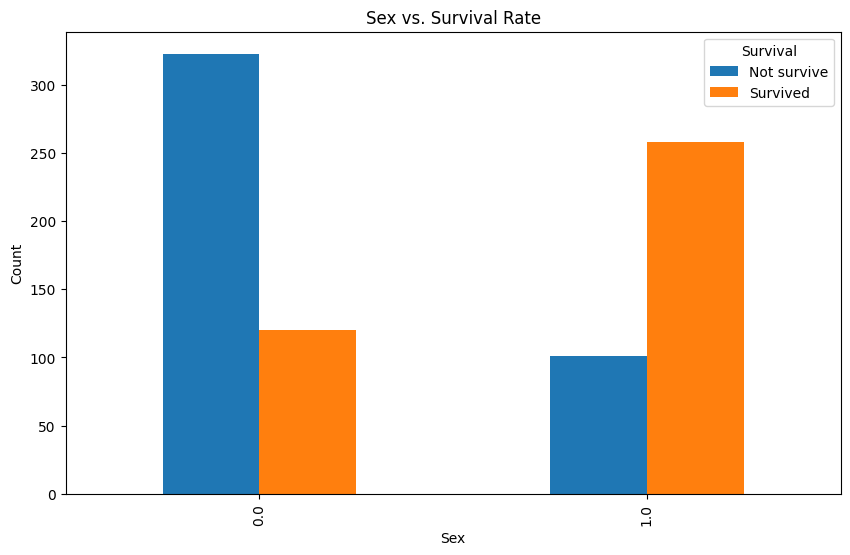

In [50]:
#Which sex was more likely to survive?
plt.figure(figsize=(20, 14))

normalized_titanic_chart = normalized_titanic.groupby(['sex', 'survived']).size().unstack().fillna(0)

ax = normalized_titanic_chart.plot(kind='bar', figsize=(10, 6), stacked=False)
plt.title('Sex vs. Survival Rate')
plt.xlabel('Sex')
plt.ylabel('Count')

plt.xticks(ticks=range(len(normalized_titanic_chart.index)), labels=normalized_titanic_chart.index)
plt.legend(title='Survival', labels=['Not survive', 'Survived'])

plt.show()
#People who had previously smoked and people who haven't smoked at all don't have the same probablity of having a stroke